# Toy model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas

Ad-hoc simple case:
- $P_{exp}$ is the physical probability distribution (ground truth), a sum of 4 gaussians; $P_0$ is the original model, given by $P_{exp}$ times $e^{-kxy}e^{-\lambda_1 x}e^{-\lambda_2 y}$.

- The observables are the two coordinates x, y, of which you know the correct (experimental) values.

- Ensemble refinement correction will provide you a correction which is $e^{-\lambda_1 x}e^{-\lambda_2 y}$ so it will improve the description without reaching yet the correct ensemble; you can require the rigid constraint $\langle (x,y)\rangle=(x,y)_{exp}$ or the soft restraint, depending on if $\sigma_i=0$ or not (data.g[i_sys][i_type][:,1]).

- Force field fitting with the correction $kxy$ will improve the description without reaching yet the correct ensemble. Here, the rigid constraint is not satistfied, so you have to put a non-zero experimental uncertainty $\sigma_i$ (the correction functional form is not able to recover the experimental values in general). A part from the relative weight of the two observables, if $\beta=0$ (no reliability on the initial coefficients), the loss function is given by the $\chi^2$ only, so the optimal solution is independent on the value of $\sigma$. 

- Only the combined approach FFF+ER is able to recover the physical ensemble.

## Set ground truth and biased distributions

Set ground truth distribution, plot it, compute populations in the four quadrants and average values of the observables X, Y (corresponding to experimental values).

Do the same for the biased distribution

Fill data variables (data.g, data.gexp, data.weights, data.f)

In [2]:
delta=0.1
upto=10
X=np.arange(-upto,upto+delta,delta)
Y=X

amplitudes=[0.5,0.15,0.4,0.1]
#centers=np.array([[2,5],[-3,1],[-5,-6],[6,-3]])
centers=np.array([[1,1],[-1,1],[-1,-1],[1,-1]])*5

#M1=0.3*np.array([[1,0.1],[0.2,1]]) # np.identity(2)
#M2=0.6*np.array([[1,0.3],[0.6,0.6]])
#M3=0.8*np.array([[1,-0.3],[-0.6,0.6]])
#M4=0.2*np.array([[1,0.3],[0.1,1]])

M1=0.9*np.identity(2)
M2=1.8*np.identity(2)
M3=2.4*np.identity(2)
M4=0.6*np.identity(2)

var_matrices=[M1,M2,M3,M4]


In [3]:
def P(): return 0
def populations(): return 0
def avs(): return 0
def lambdas_(): return 0
def k(): return 0

Variable names P, populations, avs, lambdas_, k are reserved for these functions, so that you have all the different cases at once

Possible attributes:
- exp (ground truth)
- biased (initial hypothesis), ERbias (partially biased, due to ER bias, i.e, x y), FFFbias (partially biased, due to FFF bias, i.e., xy)
- ERrew (ER reweighting, corresponding to ERbias)
- FFFrew (FFF reweighting, not corresponding to FFFbias in general)
- ERFFFrew (ER+FFF reweighting, corresponding to ground truth in this ad-hoc case)

avs.exp are the EXPERIMENTAL averages

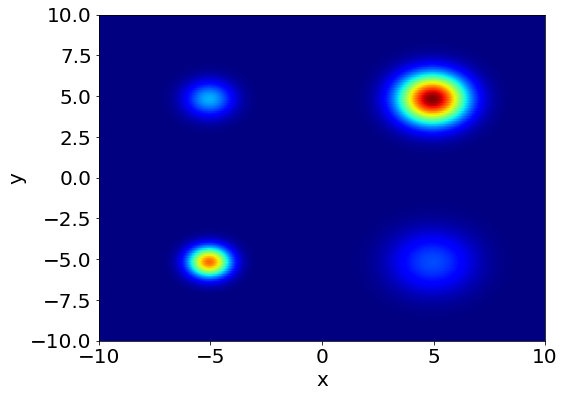

In [4]:
X_grid,Y_grid = np.meshgrid(X,Y)

P.exp=np.zeros(X_grid.shape)

for i in range(4):
    diff=np.array((X_grid-centers[i][0],Y_grid-centers[i][1]))
    P.exp+=amplitudes[i]*np.exp(-1/2*np.einsum('ijk,il,ljk->jk',diff,var_matrices[i],diff))
P.exp=P.exp/np.sum(P.exp)


plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 20
plt.scatter(X_grid,Y_grid,c=P.exp,cmap='jet')#,interpolation='none') # interpolation='lanczos'
# plt.colorbar() # arbitrary units (what matters are the ratios)
plt.xlim([-upto,upto])
plt.ylim([-upto,upto])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

compute_pop_and_avs computes:
- the populations in each of the first quadrants (starting from ++, counter-clockwise)
- the average values of X, Y

given:
- the probability distribution $P_{exp}$ (not necessarily normalized)
- X_grid, Y_grid

In [5]:
def compute_pop_and_avs(P_exp,X_grid,Y_grid):
    
    populations=[np.sum(P_exp[(X_grid>=0) & (Y_grid>=0)])/np.sum(P_exp),
    np.sum(P_exp[(X_grid<0) & (Y_grid>=0)])/np.sum(P_exp),
    np.sum(P_exp[(X_grid<0) & (Y_grid<0)])/np.sum(P_exp),
    np.sum(P_exp[(X_grid>=0) & (Y_grid<0)])/np.sum(P_exp)]

    avs=[np.sum(P_exp*X_grid)/np.sum(P_exp),np.sum(P_exp*Y_grid)/np.sum(P_exp)]

    return populations,avs



In [6]:
populations.exp,avs.exp=compute_pop_and_avs(P.exp,X_grid,Y_grid)

print('populations: ',populations.exp)
print('experimental values for X,Y respectively: ',avs.exp)


populations:  [0.5714434288614758, 0.08571645956598706, 0.1714421675495351, 0.17139794402300207]
experimental values for X,Y respectively:  [2.428484454875311, 1.5715675434352447]


In [7]:
k.biased=5e-2
lambdas_.biased=[16e-3,-4e-2]

plot ground truth and biased distributions using the same color map (linear between min, max of ground truth, issue if the biased distributions have values (much) higher than the ground truth ones)

Otherwise,

all_data = np.concatenate([P_exp, P_0])

norm = plt.Normalize(np.min(all_data), np.max(all_data))

populations:  [0.5714434288614758, 0.08571645956598706, 0.1714421675495351, 0.17139794402300207]
experimental values for X,Y respectively:  [2.428484454875311, 1.5715675434352447]
biased populations:  [0.1705882701273051, 0.3594743712147226, 0.038935880152325866, 0.43100147850564646]
biased X,Y averages:  [1.0980745154429368, 0.16187616006158279]


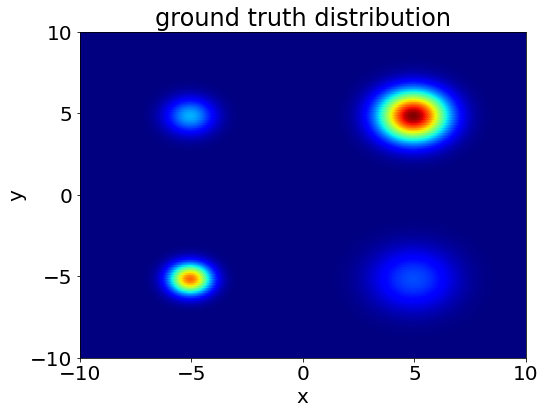

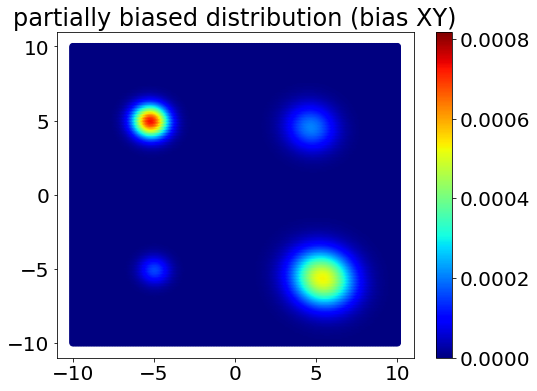

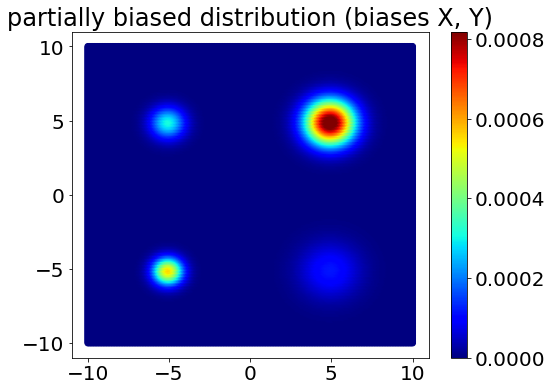

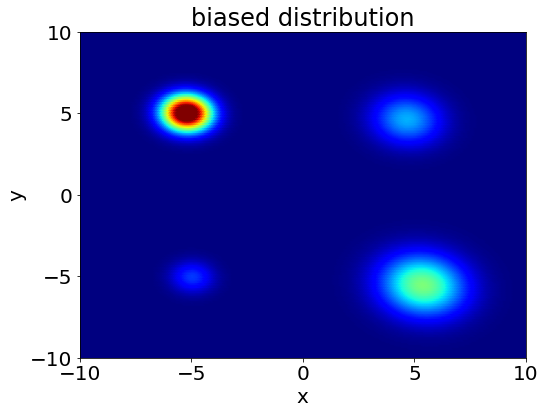

In [8]:
# 1. ground truth
print('populations: ',populations.exp)
print('experimental values for X,Y respectively: ',avs.exp)

norm=plt.Normalize(np.min(P.exp),np.max(P.exp))


plt.figure(figsize=(8,6))
plt.title('ground truth distribution')
plt.scatter(X_grid,Y_grid,c=P.exp,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
#plt.colorbar()
plt.xlim([-upto,upto])
plt.ylim([-upto,upto])
plt.xlabel('x')
plt.ylabel('y')
plt.yticks([-10,-5,0,5,10])

# 2. XY bias

P.FFFbias=P.exp*np.exp(-k.biased*X_grid*Y_grid)
P.FFFbias=P.FFFbias/np.sum(P.FFFbias)

plt.figure(figsize=(8,6))
plt.title('partially biased distribution (bias XY)')
plt.scatter(X_grid,Y_grid,c=P.FFFbias,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
plt.colorbar()

# 3. X, Y bias

P.ERbias=P.exp*np.exp(-lambdas_.biased[0]*X_grid-lambdas_.biased[1]*Y_grid)
P.ERbias=P.ERbias/np.sum(P.ERbias)

plt.figure(figsize=(8,6))
plt.title('partially biased distribution (biases X, Y)')
plt.scatter(X_grid,Y_grid,c=P.ERbias,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
plt.colorbar()

# 4. full bias 

P.biased=P.exp*np.exp(-k.biased*X_grid*Y_grid)*np.exp(-lambdas_.biased[0]*X_grid-lambdas_.biased[1]*Y_grid)
P.biased=P.biased/np.sum(P.biased)

plt.figure(figsize=(8,6))
#plt.title('fully biased distribution (biases XY, X, Y)')
plt.title('biased distribution')
plt.scatter(X_grid,Y_grid,c=P.biased,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
#plt.colorbar()
plt.xlim([-upto,upto])
plt.ylim([-upto,upto])
plt.xlabel('x')
plt.ylabel('y')
plt.yticks([-10,-5,0,5,10])
#plt.show()

populations.biased,avs.biased=compute_pop_and_avs(P.biased,X_grid,Y_grid)

print('biased populations: ',populations.biased)
print('biased X,Y averages: ',avs.biased)


In [9]:
def data(): return 0
data.g=[]
data.gexp=[]

data.g.append([np.array((np.ndarray.flatten(X_grid),np.ndarray.flatten(Y_grid))).T])
data.gexp.append([np.array([[avs.exp[0],1],[avs.exp[1],1]])])

#weights=[np.ones(len(np.ndarray.flatten(X_grid)))]
weights=[np.ndarray.flatten(P.biased)]

data.weights=weights
data.f=[(np.ndarray.flatten(X_grid)*np.ndarray.flatten(Y_grid)).reshape(-1,1)]


You could normalize data, maybe FFF and ER+FFF minimizations will be better; however, it does not happen

In [10]:
if_normalized=False

rigid constraint or soft restraint?

## 1. ensemble refinement (relative entropy maximization) 

Relative entropy maximization:

$\Gamma(\lambda)=\log Z_\lambda+\vec\lambda\cdot\vec g_{exp}+\frac{1}{2}\alpha\sum_i \lambda_i^2 \sigma_i^2$

$\sigma_i=0$ if negligible experimental error, so the $\chi^2$ term in the loss function becomes rigid constraint and the hyperparameter $\alpha$ is useless (any value $\alpha\neq 0$ is equivalent). This means constraint $\langle \vec g\rangle_\lambda=\vec g_{exp}$.

Same function as in ensemble_ref_run.py and alphabeta_run.py

In [11]:
def compute_newweights(lambdas,g,weights):
    weights=weights/np.sum(weights)
    correction=np.zeros(len(weights))

    l_from=0
    l_to=0
    for i_type in range(len(g)):#indices[0],indices[-1]):
        l_to+=np.shape(g[i_type])[1]
        correction+=np.matmul(g[i_type],lambdas[l_from:l_to])
        l_from=l_to

    shift=np.min(correction)
    correction-=shift
    newweights=np.exp(-correction)*weights
    Z=np.sum(newweights)

    return newweights/np.sum(newweights),Z,shift

In [12]:
def gamma_function(lambdas,data,weights,alpha,if_gradient):

    # 1. initialization

    nsystems=len(data.g)

    # start from weights different from the reference ensemble data.weights
    #data.weights=[]
    #for i_sys in range(nsystems):
    #    data.weights.append(weights[i_sys])

    # compute js and js_sys: indices for lambda corresponding to different systems and types of observables
    js=[]
    for i_sys in range(nsystems):
        js.append([])
        l=0
        for i_type in range(len(data.g[i_sys])):
            js[i_sys].append(len(data.g[i_sys][i_type].T))
    js_sys=np.sum(js,axis=1)
    js_sys=[0]+np.cumsum(js_sys).tolist()
    js=[0]+np.cumsum(js).tolist()

    gammaf=0

    if if_gradient:
        grad=[]
    
    for i_sys in range(nsystems):
        
        newweights,Zlambda,shift=compute_newweights(lambdas[js_sys[i_sys]:js_sys[i_sys+1]],data.g[i_sys],weights[i_sys])#js,i_sys,nsystems)
        gammaf_single=np.log(Zlambda)-shift

        ntypes=len(data.g[i_sys])
        for i_type in range(len(data.g[i_sys])):
            gammaf_single+=np.matmul(lambdas[js[i_sys*ntypes+i_type]:js[i_sys*ntypes+i_type+1]],data.gexp[i_sys][i_type][:,0])
            gammaf_single+=1/2*alpha*np.matmul(lambdas[js[i_sys*ntypes+i_type]:js[i_sys*ntypes+i_type+1]]**2,data.gexp[i_sys][i_type][:,1]**2)

        #gammaf+=alpha*gammaf_single
        gammaf+=gammaf_single

        if if_gradient:
            for i_type in range(len(data.g[i_sys])):
                av_g=np.einsum('i,ij',newweights,data.g[i_sys][i_type])
                #grad_single=-alpha*(av_g-data.gexp[i_sys][i_type][:,0]-alpha*lambdas[js[i_sys*ntypes+i_type]:js[i_sys*ntypes+i_type+1]]*data.gexp[i_sys][i_type][:,1]**2)
                grad_single=-(av_g-data.gexp[i_sys][i_type][:,0]-alpha*lambdas[js[i_sys*ntypes+i_type]:js[i_sys*ntypes+i_type+1]]*data.gexp[i_sys][i_type][:,1]**2)
                
                grad.append(grad_single)

    if if_gradient:
        grad=[item for sublist in grad for item in sublist]
        return gammaf,grad

    return gammaf

In [13]:
x0=np.zeros(2)

gtol=1e-16
alpha=0
if_gradient=True

In [14]:
gamma,grad=gamma_function(x0,data,weights,alpha,if_gradient)

In [15]:
mini=minimize(gamma_function, x0, args=(data,weights,alpha,if_gradient), method='BFGS',jac=True,options={'gtol': gtol})#, 'disp': False})

print(mini)
lambdas_.rewER=mini.x

if if_normalized:
    P.rewER=P.biased*np.exp(-lambdas_.rewER[0]*X_grid_norm-lambdas_.rewER[1]*Y_grid_norm)
else:
    P.rewER=P.biased*np.exp(-lambdas_.rewER[0]*X_grid-lambdas_.rewER[1]*Y_grid)

P.rewER=P.rewER/np.sum(P.rewER)

      fun: -0.17338367818611078
 hess_inv: array([[0.05759282, 0.01394648],
       [0.01394648, 0.0372544 ]])
      jac: array([2.44249065e-14, 7.99360578e-15])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 51
      nit: 10
     njev: 42
   status: 2
  success: False
        x: array([-0.1231973 , -0.11960469])


In [16]:
print('min. values: ',lambdas_.rewER)
print('ground truth values (opposite): ',-np.array(lambdas_.biased))

min. values:  [-0.1231973  -0.11960469]
ground truth values (opposite):  [-0.016  0.04 ]


Conclusion: if weights correspond to the distribution $P_0=P_{exp} \, e^{-\lambda_1 x}e^{-\lambda_2 y}$, then you get exactly $(-\lambda_1,-\lambda_2)$, otherwise you do not.

initial hypothesis
populations:  [0.1705882701273051, 0.3594743712147226, 0.038935880152325866, 0.43100147850564646]
experimental values for X,Y respectively:  [1.0980745154429368, 0.16187616006158279]
reweighted ensemble (Ensemble Refinement)
populations:  [0.4010385890441734, 0.2603139826584937, 0.008725281779295534, 0.3299221465180375]
experimental values for X,Y respectively:  [2.4284844548752815, 1.571567543435229]
ground truth
populations:  [0.5714434288614758, 0.08571645956598706, 0.1714421675495351, 0.17139794402300207]
experimental values for X,Y respectively:  [2.428484454875311, 1.5715675434352447]


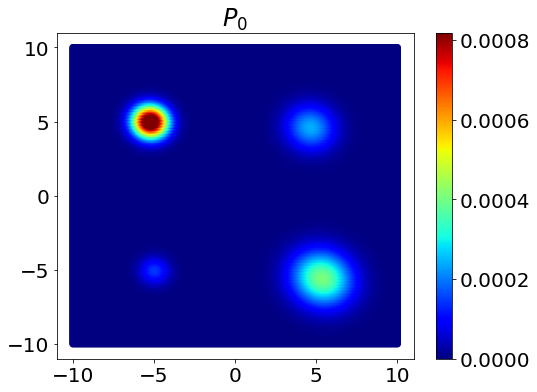

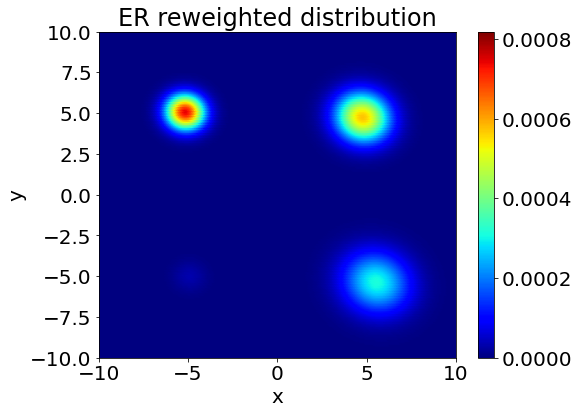

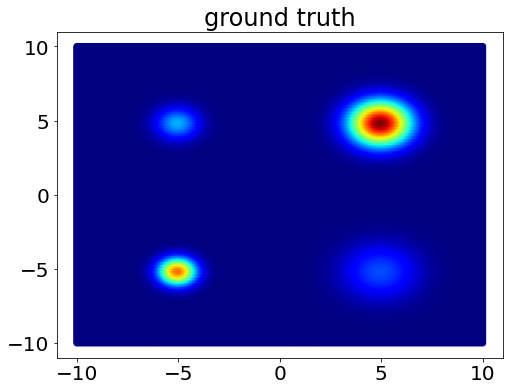

In [17]:
# 1. fully biased distribution

plt.figure(figsize=(8,6))
plt.title(r'$P_0$')
plt.scatter(X_grid,Y_grid,c=P.biased,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
plt.colorbar()

print('initial hypothesis')
print('populations: ',populations.biased)
print('experimental values for X,Y respectively: ',avs.biased)

# 2. ER reweighted distribution

plt.figure(figsize=(8,6))
#plt.title(r'reweighted $P_0$ (ensemble refinement)')
plt.title('ER reweighted distribution')
plt.scatter(X_grid,Y_grid,c=P.rewER,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
plt.colorbar()
plt.xlim([-upto,upto])
plt.ylim([-upto,upto])
plt.xlabel('x')
plt.ylabel('y')

populations.rewER,avs.rewER=compute_pop_and_avs(P.rewER,X_grid,Y_grid)

print('reweighted ensemble (Ensemble Refinement)')
print('populations: ',populations.rewER)
print('experimental values for X,Y respectively: ',avs.rewER)

# 3. ground truth distribution

plt.figure(figsize=(8,6))
plt.title(r'ground truth')
plt.scatter(X_grid,Y_grid,c=P.exp,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
#plt.colorbar()

print('ground truth')
print('populations: ',populations.exp)
print('experimental values for X,Y respectively: ',avs.exp)

## 2. force field fitting

Correction term $kxy$

Same function as in alphabeta_run.py (both for FFF and FFF+ER)

$\sigma_i=0$ if negligible experimental error, so no $\chi^2$ term in the loss function (only relative entropy) and the hyperparameter $\beta$ is useless. However, this implies the constraint $\langle \vec g\rangle_k=\vec g_{exp}$, which in general cannot be satisfied. You should minimize $-S_{rel}[P_k|P_0]$ plus the Lagrange multipliers terms

The ratio between the two hyperparameters will matter in the combined approach ER+FFF 

In [18]:
def compute_newweights2(par,lambdas,traj,obs,weights,ntypes):

        weights=weights/np.sum(weights)
        
        correction=np.matmul(np.array(traj),par)
        shift1=np.min(correction)
        correction-=shift1
        newweights1=np.exp(-correction)*weights
        Z1=np.sum(newweights1)#/np.exp(shift1)
        
        l_from=0
        l_to=0
        correction2=np.zeros(len(weights))
        for i_type in range(ntypes):#indices[0],indices[-1]):
                l_to+=np.shape(obs[i_type])[1]
                correction2+=np.matmul(obs[i_type],lambdas[l_from:l_to])
                l_from=l_to
        shift2=np.min(correction2)
        correction2-=shift2
        newweights2=np.exp(-correction2)*newweights1
        Z2=np.sum(newweights2)#/np.exp(shift1+shift2)

        return newweights1/np.sum(newweights1),Z1,shift1,newweights2/np.sum(newweights2),Z2,shift2


In [19]:
def alphabeta_lossf(par1,par2,parmap,data,alpha,beta,if_gradient,if_uNOEs,indices,if_natgrad,fixed):
    # fixed=0 par1=par_lambdas, par2=None; all gradient
    # fixed=2 par1=pars, par2=lambdas; only pars gradient
    # fixed=1 par1=lambdas, par2=pars; only lambdas gradient

    nffs=np.max([item for sublist in parmap for item in sublist])+1 # n. of force field coefficients

    if fixed==0:
        par_lambdas=par1
        par=par_lambdas[:nffs]
        lambdas=par_lambdas[nffs:]
    elif fixed==2:
        par=par1
        lambdas=par2
    elif fixed==1:
        par=par2
        lambdas=par1
    else:
        print('fixed error')
        return
        
    # 1. initialization
    nsystems=np.shape(parmap)[0]
    if if_uNOEs: ntypes=2
    else: ntypes=1

    lossf=0.0
    lossf_single=[]#np.zeros(nsystems)
    if if_gradient:
        gradP=np.zeros(nffs)
        gradL=[]#np.zeros(len(lambdas))
    if (if_natgrad==1 or if_natgrad==2):
        covPL_f=np.zeros((nffs,nffs))

    def stats(): # statistics: Srels, kish, relkish
        return 0
    stats.Srel_alpha=[]
    stats.Srel_beta=[]
    stats.Srel=[]
    stats.kish=[]
    stats.relkish=[]

    errorf=[] # error function: 1/2 chi2 or the function for uNOEs (NOT reduced, notice factor 1/2)
    for i in range(nsystems):
        errorf.append([])

    # compute js and js_sys: indices for lambda corresponding to different systems and types of observables
    n_exp=[]
    for i_sys in range(nsystems):
        n_exp.append([])
        for i_type in range(indices[-1]):
            n_exp[i_sys].append(len(data.g[i_sys][i_type].T))
        if if_uNOEs:
            i_type+=1
            n_exp[i_sys].append(len(data.g[i_sys][i_type].T))
    n_exp=np.array(n_exp)
    js_sys=np.sum(n_exp,axis=1)
    js_sys=[0]+np.cumsum(js_sys).tolist()
    js=[0]+np.cumsum(n_exp).tolist()

    # 3. for over different systems
    for i_sys in range(nsystems):

        par_sys=par[parmap[i_sys]]        
        lambdas_sys=lambdas[js_sys[i_sys]:js_sys[i_sys+1]]
        
        wP,ZP,shiftP,wPL,ZPL,shiftL=compute_newweights2(par_sys,lambdas_sys,data.f[i_sys],data.g[i_sys],data.weights[i_sys],ntypes)

        stats.kish.append(np.sum(wPL**2))
        stats.relkish.append(np.sum(wPL**2/data.weights[i_sys])*np.sum(data.weights[i_sys])) # normalized w,weights

        av_g=[]
        lambda_dot_avg=0
        #ntypes=len(data.g[i_sys])
        for i_type in range(indices[0],indices[1]):
            av_g.append(np.einsum('i,ij',wPL,data.g[i_sys][i_type]))
            errorf[i_sys].append(1/2*np.sum(((av_g[i_type]-data.gexp[i_sys][i_type][:,0])/data.gexp[i_sys][i_type][:,1])**2))
            lambda_dot_avg+=np.matmul(lambdas[js[i_sys*ntypes+i_type]:js[i_sys*ntypes+i_type+1]],av_g[i_type])
        if if_uNOEs: # last element: n_type-1
            i_type+=1#indices[1]
            av_g.append(np.einsum('i,ij',wPL,data.g[i_sys][i_type]))
            errorf[i_sys].append(1/2*np.sum((np.maximum(av_g[i_type]-data.gexp[i_sys][i_type][:,0],np.zeros(len(av_g[i_type])))/data.gexp[i_sys][i_type][:,1])**2))
            lambda_dot_avg+=np.matmul(lambdas[js[i_sys*ntypes+i_type]:js[i_sys*ntypes+i_type+1]],av_g[i_type])
        
        stats.Srel_alpha.append(lambda_dot_avg+np.log(ZPL)-np.log(ZP)-shiftL)

        weighted_f=wP[:,None]*np.array(data.f[i_sys])
        av_f=np.sum(weighted_f,axis=0)
        
        if if_natgrad==1:
            weightedPL_f=wPL[:,None]*np.array(data.f[i_sys])
            avPL_f=np.sum(weightedPL_f,axis=0)


        par_dot_avf=np.matmul(par_sys.T,av_f)

        stats.Srel_beta.append(par_dot_avf+np.log(ZP)-shiftP)
        stats.Srel.append(par_dot_avf+lambda_dot_avg+np.log(ZPL)-shiftL-shiftP)

        lossf_single.append(np.sum(np.array(errorf[i_sys]))-alpha*np.sum(np.array(stats.Srel_alpha[i_sys]))-beta*np.sum(np.array(stats.Srel_beta[i_sys])))

        # 4. compute the gradient
        if if_gradient:
            for i_type in range(indices[0],indices[1]):
                vec1=(av_g[i_type]-data.gexp[i_sys][i_type][:,0])/data.gexp[i_sys][i_type][:,1]**2-alpha*lambdas[js[i_sys*ntypes+i_type]:js[i_sys*ntypes+i_type+1]]
                if (if_natgrad==0 or if_natgrad==1): gradL.append(-vec1)

                # except only the case natural gradient and only lambda gradient
                if not ((if_natgrad==0 or if_natgrad==1) and (fixed==1)): 
                    vect=np.matmul(data.g[i_sys][i_type],vec1)
                    scal1=np.matmul(vec1,av_g[i_type])

                    # 4a. if not natural gradient, compute the lambda components of the gradient in this way
                    if if_natgrad==-1 and (fixed==0 or fixed==1):
                        gradL_single=-np.matmul(data.g[i_sys][i_type].T*wPL,vect)+scal1*av_g[i_type]
                        gradL.append(gradL_single)

                    # 4b. both for gradient and natural gradient, add this term to the phi components
                    if fixed==0 or fixed==2:
                        weightedPL_f=wPL[:,None]*np.array(data.f[i_sys])
                        avPL_f=np.sum(weightedPL_f,axis=0)
    
                        gradP_single=-np.matmul(np.array(data.f[i_sys]).T*wPL,vect)+scal1*avPL_f

            if if_uNOEs:
                i_type+=1
                vec1=np.maximum(av_g[i_type]-data.gexp[i_sys][i_type][:,0],np.zeros(len(av_g[i_type])))/data.gexp[i_sys][i_type][:,1]**2-alpha*lambdas[js[i_sys*ntypes+i_type]:js[i_sys*ntypes+i_type+1]]
                if (if_natgrad==0 or if_natgrad==1): gradL.append(-vec1)
                
                # except only the case natural gradient and only lambda gradient
                if not ((if_natgrad==0 or if_natgrad==1) and (fixed==1)): 
                    vect=np.matmul(data.g[i_sys][i_type],vec1)
                    scal1=np.matmul(vec1,av_g[i_type])
                    
                    # 4a. if not natural gradient, compute the lambda components of the gradient in this way
                    if if_natgrad==-1 and (fixed==0 or fixed==1):
                        gradL_single=-np.matmul(data.g[i_sys][i_type].T*wPL,vect)+scal1*av_g[i_type]
                        gradL.append(gradL_single)
                    
                    # 4b. both for gradient and natural gradient, add this term to the phi components
                    if fixed==0 or fixed==2:
                        gradP_single=-np.matmul(np.array(data.f[i_sys]).T*wPL,vect)+scal1*avPL_f

            if fixed==0 or fixed==2:
                # 4b. phi components
                # derivative of average of f: minus the covariance matrix
                dav_f=-np.matmul(np.transpose(weighted_f),np.array(data.f[i_sys]))+np.outer(av_f,av_f)
                
                if if_natgrad==1: covPL_f+=np.matmul(np.transpose(weightedPL_f),np.array(data.f[i_sys]))+np.outer(avPL_f,avPL_f)
                
                #inverse=np.linalg.inv(dav_f)
                #print(inverse.shape)
                #print(inverse)

                gradP_single-=beta*np.matmul(par_sys.T,dav_f)

                # derivative of average of g: minus the correlation matrix with f
                # calculated previously, to optimize

                gradP_single+=alpha*(avPL_f-av_f)

                for i in range(len(parmap[i_sys])):
                    gradP[parmap[i_sys][i]]+=gradP_single[i]

    lossf=np.sum(np.array(lossf_single))
    
    if (fixed==0 or fixed==2) and if_natgrad==1:
        gradP=np.matmul(np.linalg.inv(covPL_f),gradP)

    if if_gradient:
        if fixed==0: grad=np.array(gradP.tolist()+[item for sublist in gradL for item in sublist])
        elif fixed==1: grad=np.array([item for sublist in gradL for item in sublist])
        elif fixed==2: grad=gradP
        
        return lossf,grad,lossf_single,np.array(errorf)*2/np.array(n_exp),stats

    return lossf,lossf_single,np.array(errorf)*2/np.array(n_exp),stats


In [20]:
fixed=2

par2=np.zeros(2)
parmap=[[0]]

beta=0
alpha=0
if_uNOEs=False
indices=[0,1]
if_gradient=True
if_natgrad=False

ff_par=np.zeros(1)

In [152]:
#lossf,grad,lossf_single,chi2,stats
ff_pars=np.zeros(1)
out=alphabeta_lossf(ff_par,par2,parmap,data,alpha,beta,if_gradient,if_uNOEs,indices,if_natgrad,fixed)
out

(1.8786102016491983,
 array([70.02534639]),
 [1.8786102016491983],
 array([[1.8786102]]),
 <function __main__.alphabeta_lossf.<locals>.stats()>)

plot of the loss function ($\chi^2$) as a function of k

Text(0.5, 1.0, 'force field fitting')

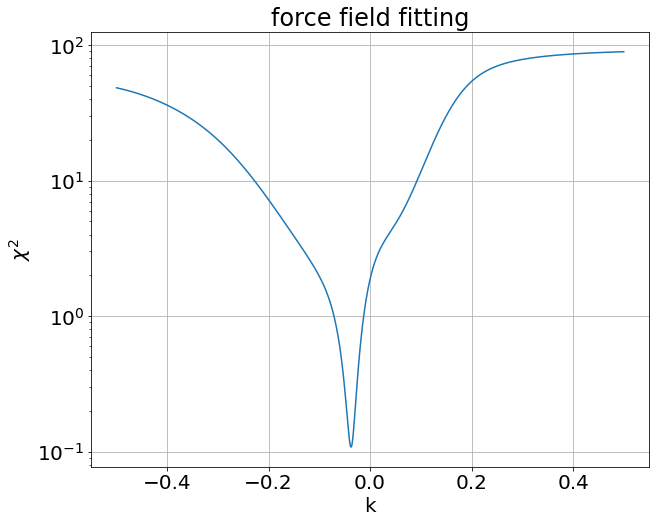

In [22]:
deltak=0.0005
ks=np.arange(-0.5,0.5+deltak,deltak)

chi2s=[]
for k_par in ks:
    chi2s.append(alphabeta_lossf(np.array([k_par]),par2,parmap,data,alpha,beta,False,if_uNOEs,indices,if_natgrad,fixed)[0])

plt.figure(figsize=(10,8))
plt.plot(ks,chi2s)
plt.xlabel('k')
plt.ylabel(r'$\chi^2$')
plt.grid()
plt.yscale('log')
plt.title('force field fitting')

notice this minimization can fail if you start from ffpar0=0 (and the gradient is below the threshold, so the minimizer says it converges)

In [23]:
ffpar0=np.zeros(1)
mini=minimize(alphabeta_lossf, ffpar0, args=(par2,parmap,data,alpha,beta,if_gradient,if_uNOEs,indices,if_natgrad,fixed), method='BFGS',jac=True,options={'gtol': gtol})#, 'disp': False})

print(mini)
k.rewFFF=mini.x

if if_normalized:
    P.rewFFF=P.biased*np.exp(-k.rewFFF*X_grid_norm*Y_grid_norm)
else:
    P.rewFFF=P.biased*np.exp(-k.rewFFF*X_grid*Y_grid)

P.rewFFF=P.rewFFF/np.sum(P.rewFFF)

      fun: 0.10804335804856285
 hess_inv: array([[0.0007622]])
      jac: array([9.54791801e-15])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 18
      nit: 9
     njev: 16
   status: 2
  success: False
        x: array([-0.0375785])


initial hypothesis
populations:  [0.1705882701273051, 0.3594743712147226, 0.038935880152325866, 0.43100147850564646]
experimental values for X,Y respectively:  [1.0980745154429368, 0.16187616006158279]
reweighted ensemble (Force Field Fitting)
populations:  [0.5161890753175014, 0.16924355511438005, 0.12168744946871167, 0.19287992009940694]
experimental values for X,Y respectively:  [2.0559788779746544, 1.849643632437938]
ground truth
populations:  [0.5714434288614758, 0.08571645956598706, 0.1714421675495351, 0.17139794402300207]
experimental values for X,Y respectively:  [2.428484454875311, 1.5715675434352447]


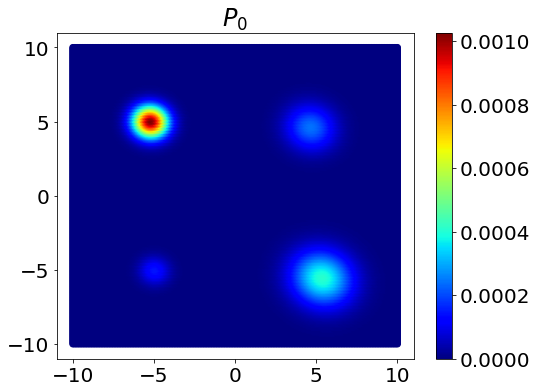

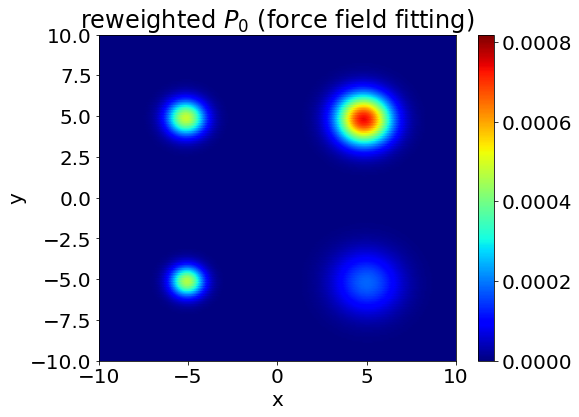

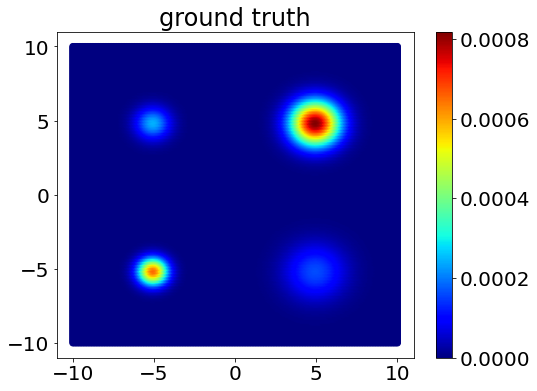

In [24]:
plt.figure(figsize=(8,6))
plt.title(r'$P_0$')
plt.scatter(X_grid,Y_grid,c=P.biased,cmap='jet')#,interpolation='none') # interpolation='lanczos'
plt.colorbar()

print('initial hypothesis')
print('populations: ',populations.biased)
print('experimental values for X,Y respectively: ',avs.biased)

# 2. force field fitting reweighting

plt.figure(figsize=(8,6))
plt.title(r'reweighted $P_0$ (force field fitting)')
plt.scatter(X_grid,Y_grid,c=P.rewFFF,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
plt.xlim([-upto,upto])
plt.ylim([-upto,upto])
plt.xlabel('x')
plt.ylabel('y')

plt.colorbar()

populations.rewFFF,avs.rewFFF=compute_pop_and_avs(P.rewFFF,X_grid,Y_grid)

print('reweighted ensemble (Force Field Fitting)')
print('populations: ',populations.rewFFF)
print('experimental values for X,Y respectively: ',avs.rewFFF)

# 3. ground truth

plt.figure(figsize=(8,6))
plt.title(r'ground truth')
plt.scatter(X_grid,Y_grid,c=P.exp,cmap='jet')#,interpolation='none') # interpolation='lanczos'
plt.colorbar()

print('ground truth')
print('populations: ',populations.exp)
print('experimental values for X,Y respectively: ',avs.exp)

Conclusion: if weights correspond to the distribution $P_0=P_{exp} \, e^{-k xy}$, then you get exactly $-k$, otherwise you try to get closer

## 3. Combined ER + FFF

In [1]:
fixed=0
if_gradient=True

lambdas=np.zeros(2)
parmap=[[0]]

beta=0#.0001
alpha=0#.0001
if_uNOEs=False
indices=[0,1]
if_natgrad=False

ff_par=np.zeros(1)

par_lambdas=np.concatenate((ff_par,lambdas))

#gtol=1e-16

NameError: name 'np' is not defined

In [75]:
# lossf,grad,lossf_single,chi2,stats
# fixed=0 par1=par_lambdas, par2=None; all gradient

ff_pars=np.zeros(1)
out=alphabeta_lossf(par_lambdas,None,parmap,data,alpha,beta,if_gradient,if_uNOEs,indices,if_natgrad,fixed)
out

(1.8786102016491983,
 array([70.02534639,  1.33040994,  1.40969138]),
 [1.8786102016491983],
 array([[1.8786102]]),
 <function __main__.alphabeta_lossf.<locals>.stats()>)

### Minimization: try to do it at once 

In [204]:
parlambdas0=np.zeros(3)#[1e-3,1e-3,1e-3]#par_lambdas#-7e-3#0.1#np.zeros(1)
mini=minimize(alphabeta_lossf, parlambdas0, args=(None,parmap,data,alpha,beta,if_gradient,if_uNOEs,indices,if_natgrad,fixed), method='BFGS',jac=True,options={'gtol': gtol})#, 'disp': False})

print(mini)
k.rewERFFF=mini.x[0]
lambdas_.rewERFFF=mini.x[1:]

if if_normalized:
    P.rewERFFF=P.biased*np.exp(-k.rewERFFF*X_grid_norm*Y_grid_norm-lambdas_.rewERFFF[0]*X_grid_norm-lambdas_.rewERFFF[1]*Y_grid_norm)
else:
    P.rewERFFF=P.biased*np.exp(-k.rewERFFF*X_grid*Y_grid-lambdas_.rewERFFF[0]*X_grid-lambdas_.rewERFFF[1]*Y_grid)
P.rewERFFF=P.rewERFFF/np.sum(P.rewERFFF)

print('par lambdas: ',k.rewERFFF,lambdas_.rewERFFF)
print('ground truth values (opposite): ',k.biased,lambdas_.biased)


      fun: 0.07942149322912995
 hess_inv: array([[ 0.00267214, -0.05153074, -0.01396764],
       [-0.05153074,  1.10398167,  0.44029118],
       [-0.01396764,  0.44029118,  0.54576268]])
      jac: array([-21.48576883,  -0.28829147,  -0.27519269])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 64
      nit: 2
     njev: 52
   status: 2
  success: False
        x: array([-0.04159023, -0.02965628,  0.01319996])
par lambdas:  -0.04159022721901866 [-0.02965628  0.01319996]
ground truth values (opposite):  0.05 [0.016, -0.04]


failed minimization, try with the nested strategy

### Nested minimization

In [27]:
def compute_newweights_par(par,f,weights):
    weights=weights/np.sum(weights)
    correction=np.matmul(f,par)
    shift=np.min(correction)
    correction-=shift
    newweights=np.exp(-correction)*weights
    Z=np.sum(newweights) # /np.exp(shift)


    return newweights/np.sum(newweights),Z,shift

In [28]:
def lossf_nested(pars,parmap,data,alpha,beta,if_uNOEs,indices,bounds): # implicit input: lambdas, gtol1
    
    global lambdas
    
    #print('lambdas: ',lambdas)

    # bounds
    if if_uNOEs: method='L-BFGS-B'
    else: method='BFGS'

    weights=[]
    for i_sys in range(len(data.g)):
        weights.append(compute_newweights_par(pars,np.array(data.f[i_sys]),data.weights[i_sys])[0])

    mini=minimize(gamma_function, lambdas, args=(data,weights,alpha,True), method=method,jac=True,bounds=bounds,options={'gtol': gtol1})#,options={'gtol': 1e-15, 'disp': False})
    lambdas=mini.x
    #print('Gamma f. minimization succeeds? ',mini.success)
    
    result=alphabeta_lossf(pars,lambdas,parmap,data,alpha,beta,True,if_uNOEs,indices,-1,2)

    return result[0],result[1],lambdas

In [29]:
def minimizer3(par_lambdas,parmap,data,alpha,beta,if_uNOEs,indices,bounds,if_returnall,gtol2):
    # implicit input: nffs
    
    global lambdas

    nffs=np.max([item for sublist in parmap for item in sublist])+1 # n. of force field coefficients

    pars0=par_lambdas[:nffs]
    lambdas=par_lambdas[nffs:] # i.e. lambdas0

    #if if_show:
    #    cb = CallbackFunctor(lossf_nested)
    #else:
    #    cb = None
    
    mini=minimize(lossf_nested, pars0, args=(parmap,data,alpha,beta,if_uNOEs,indices,bounds), method='BFGS',jac=True,options={'return_all': if_returnall,'gtol': gtol2})
    pars=mini.x
    iter=mini.nit
    failed_nested=mini.success

    if if_returnall:
        mini_steps=np.array(mini.allvecs)
    else:
        mini_steps=None

    par_lambdas=pars.tolist()+lambdas.tolist()

    return iter,failed_nested,par_lambdas,mini_steps

issue with $\alpha=0,\beta=0$: with nested minimization, if you start from zeros, then doing ensemble refinement at first step it reaches the min. value of the $\chi^2$ and the minimization is concluded

In [51]:
lossf_nested(np.array([ks[0]]),parmap,data,alpha,beta,if_uNOEs,indices,bounds=None)

(0.2077939032297259, array([-0.05970389]), array([-10.32361005,  12.05409721]))

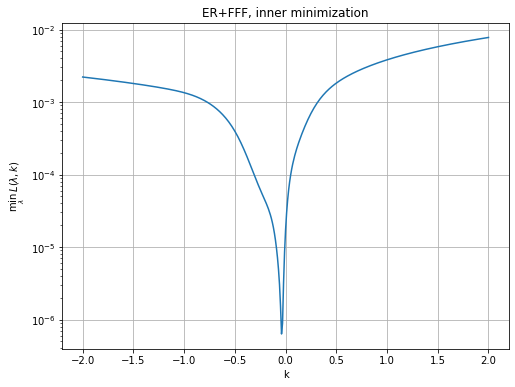

In [100]:
gtol1=1e-6
deltak=0.01
ks=np.arange(-2,2+deltak,deltak)

inner_fs=[]

for k_par in ks:
    inner_fs.append(lossf_nested(np.array([k_par]),parmap,data,alpha,beta,if_uNOEs,indices,bounds=None)[0])

plt.figure(figsize=(8,6))
plt.plot(ks,inner_fs)
plt.yscale('log')
plt.xlabel('k')
plt.ylabel(r'$\min_\lambda\, L(\lambda,k)$')
plt.title('ER+FFF, inner minimization')
plt.grid()
plt.show()


In [101]:
#parlambdas0=[-0.01,-0.01,0.01]#np.random.rand(3)*1e-1#[1e-1,1e-1,1e-1]#par_lambdas#-7e-3#0.1#np.zeros(1)
#parlambdas0=np.zeros(3)
parlambdas0=np.random.rand(3)
#parlambdas0=[-k.biased,-lambdas_.biased[0],-lambdas_.biased[1]]

gtol1=1e-6#gtol # inner minimization (Gamma function), while gtol2 is in the outer minimization
out=minimizer3(parlambdas0,parmap,data,alpha,beta,if_uNOEs,indices,bounds=None,if_returnall=True,gtol2=gtol)

print('iter: ',out[0])
print('failed ER min.? ',out[1])
print('par lambdas: ',out[2])
print('steps of the ff parameter min.: ',out[3])

print('ground truth values (opposite): ',k.biased,lambdas_.biased)

k.rewERFFF=out[2][0]
lambdas_.rewERFFF=out[2][1:2]

iter:  8
failed ER min.?  False
par lambdas:  [-0.036498793595005886, -0.02053099494268187, 0.011699812038696878]
steps of the ff parameter min.:  [[ 0.64656452]
 [-0.71960138]
 [-0.2627534 ]
 [-0.0999319 ]
 [-0.07612799]
 [-0.03178892]
 [-0.03710508]
 [-0.03628709]
 [-0.03649879]]
ground truth values (opposite):  0.05 [0.016, -0.04]


In [102]:
parlambdas_rewERFFF=out[2]
print(parlambdas_rewERFFF)

if if_normalized:
    P.rewERFFF=P.biased*np.exp(-parlambdas_rewERFFF[0]*X_grid_norm*Y_grid_norm-parlambdas_rewERFFF[1]*X_grid_norm-parlambdas_rewERFFF[2]*Y_grid_norm)
else:
    P.rewERFFF=P.biased*np.exp(-parlambdas_rewERFFF[0]*X_grid*Y_grid-parlambdas_rewERFFF[1]*X_grid-parlambdas_rewERFFF[2]*Y_grid)
P.rewERFFF=P.rewERFFF/np.sum(P.rewERFFF)

[-0.036498793595005886, -0.02053099494268187, 0.011699812038696878]


nested minimization succeeds

what about (natural) gradient descent, rather than BFGS?

### Gradient descent

In [194]:
if_natgrad=-1 # -1 gradient, 0,1 natural gradient
tol=1e-10
epsilon=1e-3

In [43]:
# force field fitting minimization

fixed=2
pars2=np.zeros(2) # lambdas
x0=np.zeros(1)

In [197]:
# FFF+ER minimization

fixed=0
#x0=np.array(parlambdas0)
x0=np.zeros(3)
pars2=None

In [195]:
def minimizer2(if_natgrad,tol,epsilon,x0,pars2,fixed,parmap,data,alpha,beta):
    ###

    # if_natgrad = -1 means gradient descent, 0 means natural gradient descent with approx. 0
    # 1 means natural gradient descent with approx. 1

    # fixed = 0 means both pars and lambdas, 1 means only lambdas minimization, 2 means only pars minimization
    print('fixed is: ',fixed)

    if_save_min=False # True if you want to save the loss function at intermediate steps

    if_gradient=True # to get the gradient (if if_natgrad=-1) or natural gradient (if if_natgrad=0,1)

    Nmax=5000000 # max. n. of iterations (at given epsilon)
    #Nmax_all=4*Nmax # max. n. of iterations (for all the epsilons)
    #epsilon=0.01 # length step: epsilon times the norm of the (natural) gradient
    # tol=0.1 # stop when Nmax is reached or norm of (natural) gradient less than tol

    print('epsilon: ',epsilon)

    if if_save_min: lossfs=[]

    x=+x0

    out=alphabeta_lossf(x,pars2,parmap,data,alpha,beta,if_gradient,if_uNOEs,indices,if_natgrad,fixed)

    lossf=out[0]
    lossf0=lossf
    length=np.linalg.norm(out[1])

    if if_save_min: 
        lossfs.append(lossf)
        print('lossf: ',lossf)
        print('gradient length:',length)
    
    lossf_new=0
    iter=0
    iter_all=0
    increments=0

    while (iter<Nmax) and (length>tol) and (increments<10):
        
        x-=epsilon*out[1]#/np.linalg.norm(out[1])
        out=alphabeta_lossf(x,pars2,parmap,data,alpha,beta,if_gradient,if_uNOEs,indices,if_natgrad,fixed)
        lossf_new=out[0]
        length=np.linalg.norm(out[1])

        if if_save_min:
            lossfs.append(lossf_new)
            print('lossf: ',lossf_new)
            print('gradient length:',length)

        if lossf_new>lossf: increments+=(lossf_new-lossf)*(iter+1) # penalize increments, in particular at long times

        else:
            lossf_min=lossf
            x_min=x+epsilon*out[1] # the ones corresponding to lossf

        iter+=1
        lossf=+lossf_new
    
    if length<=tol:
        print('converged with tolerance %f' % tol)
        failed=0
        x_min=x
        lossf_min=lossf
    else:
        print('not converged')
        failed=1

    if if_save_min: return x_min,lossf_min,iter,lossfs
    return x_min,lossf_min,iter,failed

In [198]:
out=minimizer2(if_natgrad,tol,epsilon,x0,pars2,fixed,parmap,data,alpha,beta)
print(out)

k.rewERFFF=out[0][0]
lambdas_.rewERFFF=out[0][1:]

parlambdas_rewERFFF=out[0]
P.rewERFFF=P.biased*np.exp(-parlambdas_rewERFFF[0]*X_grid*Y_grid-parlambdas_rewERFFF[1]*X_grid-parlambdas_rewERFFF[2]*Y_grid)
P.rewERFFF=P.rewERFFF/np.sum(P.rewERFFF)

fixed is:  0
epsilon:  0.001
not converged
(array([-0.03161898,  0.02140532,  0.08775055]), 0.4250140997907001, 27, 1)


### Plot results

initial hypothesis
populations:  [0.1705882701273051, 0.3594743712147226, 0.038935880152325866, 0.43100147850564646]
experimental values for X,Y respectively:  [1.0980745154429368, 0.16187616006158279]
reweighted ensemble (ER + FFF)
populations:  [0.5146851573442507, 0.14500323335341442, 0.11118672701034589, 0.2291248822919889]
experimental values for X,Y respectively:  [2.4284819718608186, 1.5715676764455315]
ground truth
populations:  [0.5714434288614758, 0.08571645956598706, 0.1714421675495351, 0.17139794402300207]
experimental values for X,Y respectively:  [2.428484454875311, 1.5715675434352447]


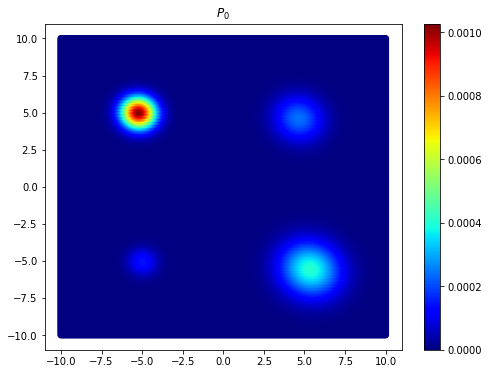

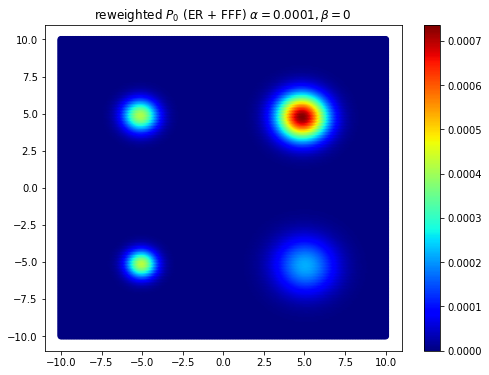

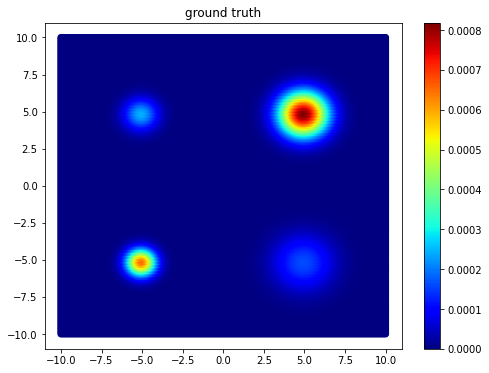

In [103]:
plt.figure(figsize=(8,6))
plt.title(r'$P_0$')
plt.scatter(X_grid,Y_grid,c=P.biased,cmap='jet')#,interpolation='none') # interpolation='lanczos'
plt.colorbar()

print('initial hypothesis')
print('populations: ',populations.biased)
print('experimental values for X,Y respectively: ',avs.biased)

plt.figure(figsize=(8,6))
plt.title(r'reweighted $P_0$ (ER + FFF) $\alpha=%s,\beta=%s$' % (alpha,beta))
plt.scatter(X_grid,Y_grid,c=P.rewERFFF,cmap='jet')#,interpolation='none') # interpolation='lanczos'
plt.colorbar()

populations.rewERFFF,avs.rewERFFF=compute_pop_and_avs(P.rewERFFF,X_grid,Y_grid)

print('reweighted ensemble (ER + FFF)')
print('populations: ',populations.rewERFFF)
print('experimental values for X,Y respectively: ',avs.rewERFFF)

plt.figure(figsize=(8,6))
plt.title(r'ground truth')
plt.scatter(X_grid,Y_grid,c=P.exp,cmap='jet')#,interpolation='none') # interpolation='lanczos'
plt.colorbar()

print('ground truth')
print('populations: ',populations.exp)
print('experimental values for X,Y respectively: ',avs.exp)

the result coming from natural gradient 1 (with also ff par contribute to the metric, better than without it) is very close to the one coming from nested minimization, they are not very close to the correct result; maybe, with initial normalization of data.g the minimization will be better

do with same tolerance

ground truth
populations:  [0.48724551726901694, 0.11794681113777244, 0.25553004743179697, 0.13927762416141368]
experimental values for X,Y respectively:  [0.5715057025558207, 0.5815564758865653]

ER + FFF (nat. gradient 1)
populations:  [0.4487596879111338, 0.15526290169706244, 0.22211509874998447, 0.17386231164181928]
experimental values for X,Y respectively:  [0.5714991154300192, 0.5815638930298879]

ER + FFF (nat. gradient 0)
populations:  [0.2987729074583503, 0.3031127435339052, 0.09293564917904892, 0.30517869982869555]
experimental values for X,Y respectively:  [0.570676964088633, 0.5820686399342996]

ER + FFF (nested)
populations:  [0.4054432758592442, 0.19797730082217344, 0.18423530163041188, 0.21234412168817024]
experimental values for X,Y respectively:  [0.5715057023077726, 0.5815564804324224]

ER + FFF (gradient descent)
populations:  [0.4415048859357942, 0.1623763328598445, 0.2157846225903432, 0.18033415861401816]
experimental values for X,Y respectively:  [0.5715053149392679, 0.5815569908864329]

Ensemble Refinement
populations:  [0.4054432758592442, 0.19797730082217344, 0.18423530163041188, 0.21234412168817024]
experimental values for X,Y respectively:  [0.5715057023077726, 0.5815564804324224]

Force Field Fitting
populations:  [0.5474774300530288, 0.07849088038619834, 0.310800657758645, 0.06323103180212783]
experimental values for X,Y respectively:  [0.33002719165762273, 0.8014178013604246]



## Recap results

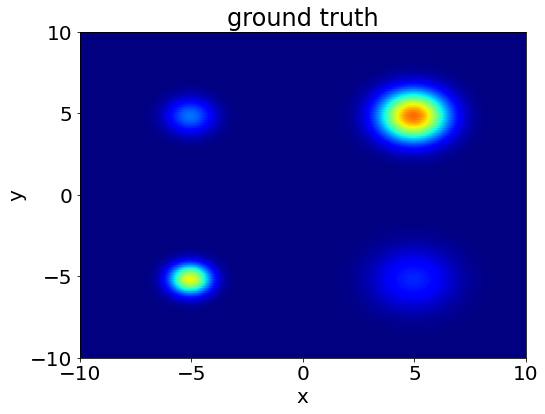

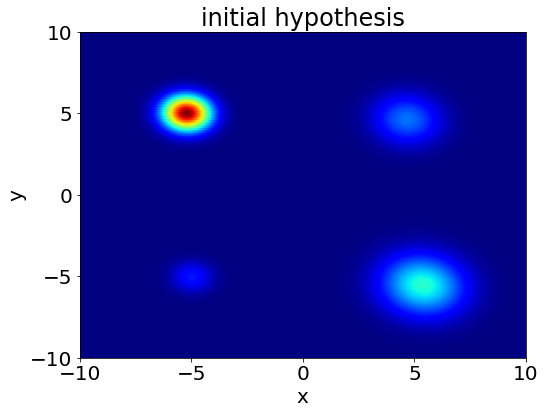

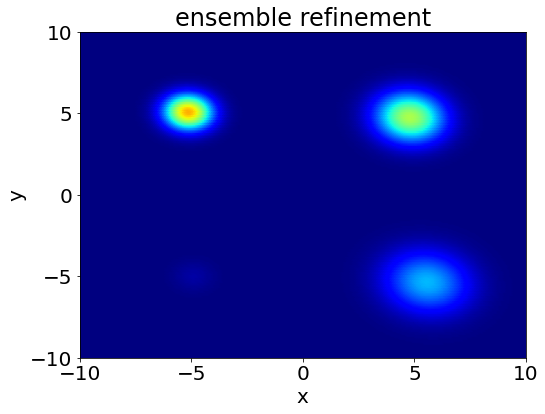

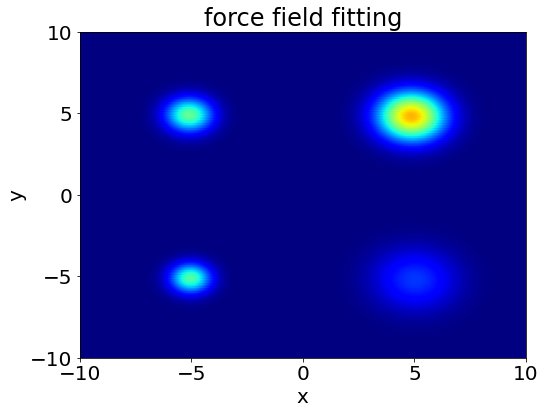

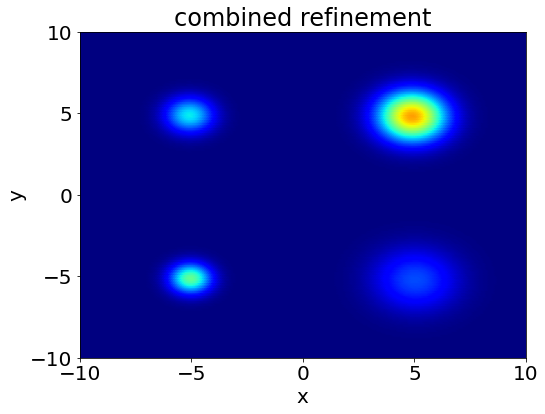

In [41]:
all_data = np.concatenate([P.exp, P.biased, P.rewER, P.rewFFF])
norm = plt.Normalize(np.min(all_data), np.max(all_data))

plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 20
plt.title('ground truth')
plt.scatter(X_grid,Y_grid,c=P.exp,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
# plt.colorbar() # arbitrary units (what matters are the ratios)
plt.xlim([-upto,upto])
plt.ylim([-upto,upto])
plt.xlabel('x')
plt.ylabel('y')
plt.yticks([-10,-5,0,5,10])
plt.show()

plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 20
plt.title('initial hypothesis')
plt.scatter(X_grid,Y_grid,c=P.biased,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
# plt.colorbar() # arbitrary units (what matters are the ratios)
plt.xlim([-upto,upto])
plt.ylim([-upto,upto])
plt.xlabel('x')
plt.ylabel('y')
plt.yticks([-10,-5,0,5,10])
plt.show()

plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 20
plt.title('ensemble refinement')
plt.scatter(X_grid,Y_grid,c=P.rewER,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
# plt.colorbar() # arbitrary units (what matters are the ratios)
plt.xlim([-upto,upto])
plt.ylim([-upto,upto])
plt.xlabel('x')
plt.ylabel('y')
plt.yticks([-10,-5,0,5,10])
plt.show()

plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 20
plt.title('force field fitting')
plt.scatter(X_grid,Y_grid,c=P.rewFFF,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
# plt.colorbar() # arbitrary units (what matters are the ratios)
plt.xlim([-upto,upto])
plt.ylim([-upto,upto])
plt.xlabel('x')
plt.ylabel('y')
plt.yticks([-10,-5,0,5,10])
plt.show()

plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 20
plt.title('combined refinement')
plt.scatter(X_grid,Y_grid,c=P.rewERFFF,cmap='jet',norm=norm)#,interpolation='none') # interpolation='lanczos'
# plt.colorbar() # arbitrary units (what matters are the ratios)
plt.xlim([-upto,upto])
plt.ylim([-upto,upto])
plt.xlabel('x')
plt.ylabel('y')
plt.yticks([-10,-5,0,5,10])
plt.show()

In [79]:
Srel=pandas.Series()

# minus Srel
Srel['biased']=np.sum(np.log(P.biased/P.exp)*P.biased)
Srel['ERFFF']=np.sum(np.log(P.rewERFFF/P.exp)*P.rewERFFF)
Srel['ER']=np.sum(np.log(P.rewER/P.exp)*P.rewER)
Srel['FFF']=np.sum(np.log(P.rewFFF/P.exp)*P.rewFFF)

print(Srel)

biased    0.720113
ERFFF     0.044896
ER        0.400502
FFF       0.047201
dtype: float64


/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [41]:
print(dir(lambdas_))

print('lambdas: ')
print(lambdas_.biased)
print(lambdas_.rewER)
print(lambdas_.rewERFFF)

print('k: ')
print(k.biased)
print(k.rewFFF)
print(k.rewERFFF)

['__annotations__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'biased', 'rewER', 'rewERFFF']
lambdas: 
[0.016, -0.04]
[-0.01599999  0.03999968]
[-0.01610340698956207]
k: 
0
[-0.02018355]
-0.0001235674914885526


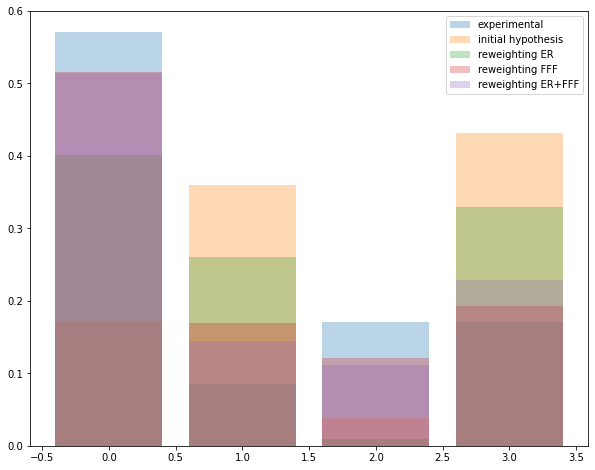

In [80]:
plt.figure(figsize=(10,8))
plt.rcParams['font.size'] = 10
plt.bar(np.arange(4),populations.exp,label='experimental',alpha=0.3)
plt.bar(np.arange(4),populations.biased,label='initial hypothesis',alpha=0.3)
plt.bar(np.arange(4),populations.rewER,label='reweighting ER',alpha=0.3)
plt.bar(np.arange(4),populations.rewFFF,label='reweighting FFF',alpha=0.3)
plt.bar(np.arange(4),populations.rewERFFF,label='reweighting ER+FFF',alpha=0.3)
plt.legend()
